In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    if distStep < 1:
        dists = np.array(range(0, int(maxDist*10000), int(distStep*10000)))
        dists = dists/10000
    else:   
        dists = np.array(range(0, maxDist, distStep))
    return dists

In [3]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))

In [4]:
def buildGraphFromImages(imgs, dists, Ps):
    eta = 0.5*(dists[-1]-dists[0]) # max dist of neighboring labels
    sigmaC = 10 # tolerance data term
    epsilon = 500 # for lambda
    omegaS = 0.5*(dists[-1]-dists[0]) # smoothness strength
    
    img1 = imgs[0]
    imgs = imgs[1:]
    
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = Ps[0][0:3], Ps[0][3:6], Ps[0][6]
    neighborFrameParams = []
    for t in range(1, Ps.shape[0]):
        Kp, Rp, Tp = Ps[t][0:3,:], Ps[t][3:6, :], Ps[t][6, :]
        mat2Temp = Kp.dot(np.transpose(Rp))
        mat1Temp = mat2Temp.dot(R).dot(np.linalg.inv(K))
        mat3Temp = mat2Temp.dot((T-Tp))
        neighborFrameParams.append([mat1Temp, mat3Temp])
#     neighborFrameParams = np.array(neighborFrameParamsList)
    print("neighborFrameParams:")
    print(len(neighborFrameParams))
    
    #     print(Kp, Rp, Tp)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
            pairwiseCost[i][j] = min(abs(dists[i]-dists[j]),eta)

    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(sigmaC/(255+sigmaC))
#     print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels; update edgeweights
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            if(rightNodeNo < nNodes and c < imgWidth-1):
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo])
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeIndex+=1
            
            leftNodeRGB = img1[r, c]
            ULambdaDenominator = 0
            neighborhoodSize = 0
            for ry in [r-1, r+1]:
                for cy in [c-1, c+1]:
                    if(ry >= 0 and ry < imgHeight and cy >=0 and cy < imgWidth):
                        neighborhoodSize = neighborhoodSize + 1
                        neighborRGB = img1[ry, cy]
                        ULambdaDenominator = ULambdaDenominator + (1/(getRgbDist(leftNodeRGB, neighborRGB) + epsilon))
            ULambda = neighborhoodSize/ULambdaDenominator
            for ry in [r-1, r+1]:
                for cy in [c-1, c+1]:
                    if(ry >= 0 and ry < imgHeight and cy >=0 and cy < imgWidth):
                        neighborRGB = img1[ry, cy]
#                         print(leftNodeRGB, neighborRGB)
                        lambdaXEachY = omegaS*ULambda/(getRgbDist(leftNodeRGB, neighborRGB) + epsilon)
                        edgeweights
#                         pairwiseCost = pairwiseCost + lambdaXEachY*pairwiseCost
            # unary cost /= data term:
            for t in range(0, len(neighborFrameParams)):
                mat1 = neighborFrameParams[t][0]
                mat3 = neighborFrameParams[t][1]
                img2 = imgs[t]
                for i in range(0, nDists):
                    dist = dists[i]
                    # make inhomogeneous coordinate of x:
                    x = np.array([r, c, 1])
                    xInfinite = mat1.dot(x)
                    if(xInfinite[2] != 0):
                        xInfinite = xInfinite/xInfinite[2]
                    ep = dist*mat3
                    xp = xInfinite + ep
                    # normalize x'
                    xp = xp/xp[2]
                    if (xp[0] < imgHeight and xp[0] >= 0 and xp[1] < imgWidth and xp[1] >= 0):
                        rightNodeRGB = img2[int(xp[0]), int(xp[1])]
                        rho = sigmaC /(getRgbDist(leftNodeRGB, rightNodeRGB)+sigmaC)
                        unaryCosts[nodeNo, i] = unaryCosts[nodeNo, i] + rho
        
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [5]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

In [6]:
P = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])
Pp = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9998813487,0.0148994942,0.0039106989],
               [-0.0148907594,0.9998865876,-0.0022532664],
               [-0.0039438279,0.0021947658,0.9999898146],
               [-9.9909793759,0.2451742154,0.1650832670]])
# print(P, Pp)
# Ps = np.array([[P], [Pp]])
Ps = np.array([P, Pp])
print(Ps)
print(Ps[0])
print(Ps[0][6])
print(Ps[0][0][1])

[[[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
  [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
  [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
  [ 9.99881349e-01  1.48994942e-02  3.91069890e-03]
  [-1.48907594e-02  9.99886588e-01 -2.25326640e-03]
  [-3.94382790e-03  2.19476580e-03  9.99989815e-01]
  [-9.99097938e+00  2.45174215e-01  1.65083267e-01]]]
[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e

In [7]:
MAX_DIST = 0.01
DIST_STEP = 0.0005

In [8]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045
 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]


In [9]:
leftImg = cv2.imread('test00.jpg')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('test09.jpg')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)
imgs = np.array([leftImg, rightImg])

In [10]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(imgs, dists, Ps)
# print("pairwiseCost, unaryCosts")
print("pairwiseCost:")
print(pairwiseCost)
print("unaryCost:")
print(unaryCosts)

neighborFrameParams:
1


D:\temp\ipykernel_22696\3562442048.py:86: RuntimeWarning: overflow encountered in add
  pairwiseCost = pairwiseCost + lambdaXEachY*pairwiseCost


pairwiseCost:
[[ 0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf  0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf  0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf  0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf  0. inf inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf  0. inf inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf  0. inf inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf inf  0. inf inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf inf inf  0. inf inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf inf inf inf  0. inf inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf inf inf inf inf  0. inf inf inf inf inf inf inf
  inf inf]
 [inf inf inf inf inf inf inf inf inf inf inf  0. i

12.75


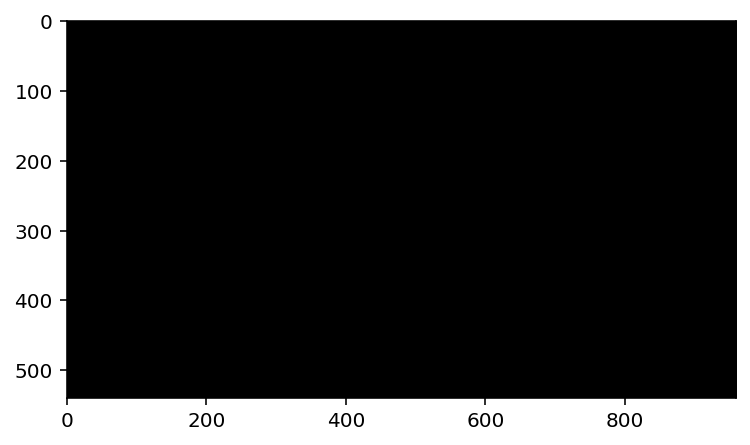

[0 0 0 ... 0 0 0]


In [11]:
mLambda = 1
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

In [13]:
# for i in range(0,unaryCosts.shape[0]):
#     for j in range(0, unaryCosts.shape[1]):
#         print(unaryCosts[i, j])

0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.03773584905660377


0.9200887902330743
0.8710691823899371
0.894878706199461
0.9200887902330743
0.8710691823899371
0.894878706199461
0.894878706199461
0.894878706199461
0.18625070054175225
0.10036632922361838
0.1088258964499687
0.10023584905660377
0.09402102729300152
0.10607297889715048
0.09402102729300152
0.08675545689974103
0.03773584905660377
0.9752358490566038
0.9752358490566038
0.9468267581475128
1.0377358490566038
0.9468267581475128
0.9752358490566038
0.9752358490566038
0.9468267581475128
0.9468267581475128
0.9200887902330743
0.9752358490566038
0.13267255791736327
0.1012951710905021
0.11055138303718628
0.09455403087478559
0.0866754901659023
0.09487870619946091
0.0972596585804133
0.0892822408091811
0.03773584905660377
1.0054777845404748
1.0054777845404748
0.9752358490566038
0.9468267581475128
0.894878706199461
0.9468267581475128
1.0054777845404748
0.9200887902330743
0.9200887902330743
1.0054777845404748
1.0054777845404748
0.11947971826641304
0.09714178965066317
0.10076105914063738
0.09228130360205833


0.39918163218913394
0.20627517489930042
0.47891231964483905
0.41273584905660377
0.9468267581475128
0.34701419957206775
0.6499807470157873
0.03773584905660377
0.03773584905660377
0.10225197808886183
0.23128423615337795
0.14449741489290271
0.21845874062286885
0.16325886160890504
0.19079707354639966
0.7195540308747856
0.6760337213970292
0.3055929919137466
0.32345013477088946
0.5377358490566038
0.46630727762803237
0.1693147964250248
0.27773584905660376
0.4431412544620092
0.43247269116186693
0.46630727762803237
0.26329975883103984
0.03773584905660377
0.03773584905660377
0.09946424411833216
0.20722737448033257
0.1408286325617584
0.19317626356437576
0.14118412491867274
0.18698958039988733
0.374814500741997
0.30089374379344586
0.22760926677812274
0.30322257472032055
0.374814500741997
0.29860541427399506
0.2616164460715292
0.22292103424178894
0.4035895075931891
0.35023584905660377
0.7195540308747856
0.35023584905660377
0.03773584905660377
0.03773584905660377
0.11426646130150173
0.26329975883103

0.34385829803619555
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.31296520685476886
0.21525064195601207
0.5377358490566038
0.4922813036020583
0.2567139512463848
0.30322257472032055
0.43247269116186693
0.38256343526350034
0.21317444554783183
0.22881865160437448
0.26674348264439
0.1320754716981132
0.2898366893927382
0.2836374884008661
0.23510427010923535
0.29414610546686015
0.2551271534044299
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.1262314242778427
0.10967829509976923
0.564051638530288
0.4081062194269741
0.3261973875181422
0.3347655520269007
0.6377358490566039
0.6377358490566039
0.735410267661255
0.38657305835892936
0.2777358490566038
0.13740362314298252
0.47891231964483905
0.26500857632933106
0.35688478522681655
0.3318534961154273
0.6760337213970293
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.1075032909170689
0.1063857346401278
0.35688478522681655
0.36740617872693343
0.281638288080994
0.3207547169811321
0.5064858490566038
0.3865730

1.0054777845404748
0.9468267581475128
0.9468267581475128
0.9468267581475128
0.9468267581475128
0.894878706199461
1.0054777845404748
0.9468267581475128
0.03773584905660377
0.9468267581475128
0.8710691823899371
0.8710691823899371
1.0054777845404748
0.9468267581475128
1.0377358490566038
1.0054777845404748
1.0054777845404748
1.0054777845404748
1.0377358490566038
0.9200887902330743
1.0054777845404748
0.9468267581475128
0.9468267581475128
0.9468267581475128
0.9468267581475128
0.894878706199461
1.0054777845404748
0.9468267581475128
0.03773584905660377
0.9468267581475128
0.8710691823899371
0.8710691823899371
0.9468267581475128
0.9468267581475128
1.0054777845404748
1.0377358490566038
1.0377358490566038
1.0054777845404748
1.0377358490566038
1.0054777845404748
1.0054777845404748
1.0054777845404748
0.9468267581475128
1.0054777845404748
1.0054777845404748
0.894878706199461
1.0054777845404748
0.9468267581475128
0.03773584905660377
0.9752358490566038
0.894878706199461
0.894878706199461
1.037735849056

0.2195540308747856
0.23907813093579838
0.1408286325617584
0.4223512336719884
0.27211084905660377
0.281638288080994
0.22292103424178894
0.18625070054175225
0.03773584905660377
0.03773584905660377
0.22292103424178897
0.45440251572327045
0.4922813036020583
0.1862507005417523
0.1687402158688308
0.15492334905660377
0.47891231964483905
0.32075471698113206
0.49927431059506533
0.37481450074199707
0.3407661520869068
0.36740617872693343
0.1513722126929674
0.4431412544620092
0.38256343526350034
0.6146589259796807
0.3603164942178941
0.28773584905660377
0.03773584905660377
0.03773584905660377
0.22066267832489644
0.4035895075931891
0.49927431059506533
0.2195540308747856
0.23381428042915278
0.22292103424178894
0.6377358490566037
0.29414610546686015
0.3948787061994609
0.4081062194269741
0.4035895075931891
0.4127358490566038
0.1617027912053641
0.2446324007807417
0.2963565387117762
0.5932914046121593
0.3129652068547689
0.27395632149754867
0.03773584905660377
0.03773584905660377
0.241817481709665
0.57345

0.7195540308747855
0.20533361441973227
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.9200887902330743
0.4789123196448391
0.32075471698113206
0.1693147964250248
0.21215445370776656
0.3991816321891339
0.3991816321891339
0.26674348264439
0.7694431661297745
0.5216068167985393
0.3638228055783429
0.5549772283669485
0.7520215633423181
0.6377358490566039
0.735410267661255
0.6499807470157873
0.22641509433962265
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.735410267661255
0.7195540308747856
0.24752605884681356
0.1923750243143357
0.2796713329275715
0.806966618287373
0.31551362683438156
0.5462104253277903
0.4725184577522559
0.689909762100082
0.82720953326713
0.4992743105950653
0.6037735849056605
0.6259711431742508
0.6146589259796807
0.6377358490566037
0.2836374884008661
0.03773584905660377
0.03773584905660377
0.03773584905660377
0.7195540308747855
0.5462104253277903
0.29860541427399506
0.44869475316619284
0.3377358490566038
0.6499807470157875
0.4789123196448391
0.6

1.0377358490566038
1.0377358490566038
0.9752358490566038
0.9752358490566038
0.894878706199461
0.9200887902330743
0.9200887902330743
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.03773584905660377
1.0377358490566038
1.0377358490566038
1.0377358490566038
0.9752358490566038
0.9752358490566038
1.0377358490566038
0.9200887902330743
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9200887902330743
0.9200887902330743
0.8485466598674146
0.8710691823899371
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.03773584905660377
1.0377358490566038
1.0377358490566038
1.0377358490566038
0.9752358490566038
0.9752358490566038
1.0377358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9200887902330743
0.9200887902330743
0.8485466598674146
0.894878706199461
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.9200887902330743
0.03773584905660377
1.005477784

0.4992743105950653
0.6259711431742508
0.6146589259796807
0.6146589259796807
0.32619738751814226
0.29414610546686015
0.38256343526350034
0.22881865160437445
0.7195540308747855
0.4431412544620092
0.12837029014421705
0.43247269116186693
0.03773584905660377
0.09308640256213882
0.10950618398483344
0.09655937846836848
0.10950618398483344
0.12248161176846817
0.3786449399656947
0.5932914046121593
0.4992743105950653
0.5295391277451285
0.6146589259796807
0.3603164942178941
0.2796713329275715
0.2446324007807417
0.44314125446200914
0.22641509433962265
0.5932914046121593
0.6146589259796807
0.13388969521044994
0.29414610546686015
0.03773584905660377
0.08990976210008203
0.11055138303718628
0.10076105914063738
0.13177973620393918
0.12782593914669385
0.1923750243143357
0.38657305835892936
0.34701419957206775
0.4992743105950653
0.48549704308645447
0.5377358490566038
0.5295391277451285
0.38657305835892936
0.6627358490566038
0.29414610546686015
0.5216068167985393
0.7694431661297745
0.163786269224671
0.374

0.17792276494445422
0.1948039118838289
0.20077932731747333
0.35688478522681655
0.18196661828737298
0.2535631871861002
0.17409948542024015
0.21630727762803234
0.18848961790082486
0.1900201130159946
0.03773584905660377
0.03773584905660377
0.24043855175930645
0.21845874062286882
0.2505018065034123
0.22066267832489644
0.33773584905660375
0.2535631871861002
0.20722737448033257
0.241817481709665
0.19902617163724892
0.23773584905660378
0.16170279120536413
0.35352532274081433
0.2446324007807417
0.27967133292757157
0.1931762635643758
0.241817481709665
0.22178492881120498
0.22407125278331186
0.03773584905660377
0.03773584905660377
0.45440251572327045
0.24900345469040658
0.2986054142739951
0.23907813093579838
0.28773584905660377
0.35688478522681655
0.24752605884681353
0.26674348264439
0.23510427010923535
0.30089374379344586
0.2898366893927382
0.3603164942178941
0.41273584905660377
0.291973137192197
0.26329975883103984
0.26674348264439
0.2632997588310399
0.25202156334231807
0.03773584905660377
0.0

0.9752358490566038
0.3032225747203206
0.14682675814751286
0.4725184577522559
0.08520420348698352
0.0874870928376983
0.0874870928376983
0.08431969998828079
0.08565917174030985
0.08635821534509647
0.08339794951322477
0.08558273900875688
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9200887902330743
0.8710691823899371
0.9752358490566038
0.9468267581475128
0.6259711431742508
0.19158200290275762
0.9200887902330743
0.08612294583079733
0.08699693280044614
0.08659578391002397
0.08453772113148678
0.08596736031062306
0.08604502780056512
0.08543060263371029
0.08954932055919444
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9752358490566038
0.9200887902330743
0.9468267581475128
0.9752358490566038
0.9468267581475128
0.806966618287373
0.4223512336719884
0.9200887902330743
0.09178990311065782
0.08798710533801081
0.08659578391002397
0.08475779263027147
0.08505446104398548
0.08675545689974103
0.08659578391002397
0.0961016

0.12345013477088948
0.10049735533275439
0.0970243866060109
0.10197567775039393
0.03773584905660377
0.21114625368088122
0.689909762100082
0.1262314242778427
0.12320593452668924
0.45440251572327045
0.13032844164919635
0.11731144587357992
0.17598469698287106
0.14118412491867274
0.14603909815407667
0.23907813093579838
0.11465892597968069
0.11838101034692636
0.14012492755489728
0.11816480348019626
0.14226546578134244
0.11180992313067784
0.11180992313067784
0.1144621917676012
0.03773584905660377
0.14012492755489728
0.18127651891306312
0.564051638530288
0.18925100057175528
0.29860541427399506
0.16594097726173196
0.15051780394382183
0.281638288080994
0.1931762635643758
0.2796713329275715
0.6259711431742508
0.13674575004670278
0.12892125939095028
0.18698958039988733
0.15492334905660377
0.19317626356437576
0.1693147964250248
0.15267837779223595
0.22178492881120498
0.03773584905660377
0.1244410513687425
0.14118412491867274
0.18059299191374661
0.19158200290275762
0.30089374379344586
0.255127153404

0.24900345469040658
0.26500857632933106
0.2583240843507214
0.23381428042915278
0.2963565387117762
0.3535253227408143
0.3104631217838765
0.4127358490566038
0.23381428042915278
0.21420643729189787
0.03773584905660377
0.03773584905660377
0.3347655520269007
0.4377358490566038
0.09553931726469625
0.09318871412129878
0.09971932013098395
0.31551362683438156
0.45440251572327045
0.41273584905660377
0.45440251572327045
0.39067702552719197
0.3991816321891339
0.2986054142739951
0.4789123196448391
0.5064858490566038
0.4854970430864545
0.5932914046121593
0.31046312178387653
0.26850507982583455
0.03773584905660377
0.03773584905660377
0.5139263252470799
0.3638228055783429
0.1140717269191992
0.0934979308409904
0.09610160781146758
0.181966618287373
0.4922813036020583
0.4922813036020583
0.5064858490566038
0.4854970430864545
0.5462104253277902
0.4223512336719884
0.5295391277451285
0.4273462386669934
0.564051638530288
0.46630727762803237
0.48549704308645447
0.4127358490566038
0.03773584905660377
0.03773584

0.564051638530288
0.2616164460715292
0.2490034546904066
0.03773584905660377
0.03773584905660377
0.17792276494445425
0.24321530111139827
0.14047557508400105
0.6146589259796807
0.23773584905660378
0.18773584905660376
0.2796713329275715
0.5064858490566038
0.8485466598674146
0.806966618287373
0.5549772283669485
0.689909762100082
0.6377358490566039
0.5216068167985394
0.7877358490566039
0.8710691823899371
0.21014964216005205
0.19237502431433576
0.03773584905660377
0.03773584905660377
0.15870359099208767
0.26850507982583455
0.14226546578134247
0.4789123196448391
0.35023584905660377
0.22178492881120498
0.19398584905660377
0.3407661520869068
0.6499807470157875
0.46630727762803237
0.6627358490566038
0.4377358490566038
0.5932914046121593
0.5932914046121593
0.4725184577522559
0.5216068167985393
0.1799159438433336
0.19563058589870902
0.03773584905660377
0.03773584905660377
0.20348170541019495
0.44314125446200914
0.13545571876344414
0.259958071278826
0.38256343526350034
0.259958071278826
0.207227374

KeyboardInterrupt: 